# Speed Pipeline Demo

This notebook demonstrates the speed calculation functions in `ml/data/speed.py`:

1. **`distance_delta`** - Compute distance traveled between consecutive GPS points
2. **`speed`** - Compute speed from distance and time deltas

These functions are used by `speed_pipeline()` in `ml/pipelines.py`.

In [2]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import speed functions
from ml.data.speed import distance_delta, speed

print("Speed functions loaded successfully!")

Speed functions loaded successfully!


---
## 1. `distance_delta`

Computes the great-circle distance (Haversine) between consecutive GPS points.

### Function Signature
```python
def distance_delta(
    df: pd.DataFrame,
    lat_column: str,
    lon_column: str,
    output_column: str
) -> pd.DataFrame:
```

**Returns the modified DataFrame (also modifies in-place).**

**Note:** First row gets `NaN` since there's no previous point.

In [3]:
# Create sample DataFrame with GPS coordinates
# Simulating a shuttle moving along a route
df_dist = pd.DataFrame({
    'vehicle_id': [1, 1, 1, 1, 1],
    'latitude': [
        42.7302,   # Start
        42.7310,   # ~89 meters north
        42.7310,   # Same position (stopped)
        42.7320,   # ~111 meters north
        42.7335    # ~167 meters north
    ],
    'longitude': [
        -73.6762,
        -73.6762,
        -73.6762,
        -73.6770,
        -73.6780
    ],
    'epoch_seconds': [0, 5, 10, 15, 20]  # 5-second intervals
})

print("BEFORE distance_delta:")
print(df_dist)
print(f"\nColumns: {list(df_dist.columns)}")

BEFORE distance_delta:
   vehicle_id  latitude  longitude  epoch_seconds
0           1   42.7302   -73.6762              0
1           1   42.7310   -73.6762              5
2           1   42.7310   -73.6762             10
3           1   42.7320   -73.6770             15
4           1   42.7335   -73.6780             20

Columns: ['vehicle_id', 'latitude', 'longitude', 'epoch_seconds']


In [4]:
# Apply distance_delta
df_dist = distance_delta(df_dist, 'latitude', 'longitude', 'distance_km')

print("AFTER distance_delta:")
print(df_dist)
print(f"\nNew column added: 'distance_km'")

AFTER distance_delta:
   vehicle_id  latitude  longitude  epoch_seconds  distance_km
0           1   42.7302   -73.6762              0          NaN
1           1   42.7310   -73.6762              5     0.088956
2           1   42.7310   -73.6762             10     0.000000
3           1   42.7320   -73.6770             15     0.128972
4           1   42.7335   -73.6780             20     0.185716

New column added: 'distance_km'


In [5]:
# Interpret the results
print("Distance Calculation Results:")
print("="*60)
for i, row in df_dist.iterrows():
    if pd.isna(row['distance_km']):
        print(f"Row {i}: NaN (first point, no previous)")
    else:
        print(f"Row {i}: {row['distance_km']*1000:.1f} meters from previous point")

print(f"\nTotal distance: {df_dist['distance_km'].sum()*1000:.1f} meters")

Distance Calculation Results:
Row 0: NaN (first point, no previous)
Row 1: 89.0 meters from previous point
Row 2: 0.0 meters from previous point
Row 3: 129.0 meters from previous point
Row 4: 185.7 meters from previous point

Total distance: 403.6 meters


---
## 2. `speed`

Computes speed from distance and time deltas.

**Formula:** `speed = distance / time_delta * 3600` (converts km/s to km/h)

### Function Signature
```python
def speed(
    df: pd.DataFrame,
    distance_column: str,
    time_column: str,
    output_column: str
) -> pd.DataFrame:
```

**Returns the modified DataFrame (also modifies in-place).**

In [6]:
print("BEFORE speed:")
print(df_dist[['latitude', 'longitude', 'epoch_seconds', 'distance_km']])

BEFORE speed:
   latitude  longitude  epoch_seconds  distance_km
0   42.7302   -73.6762              0          NaN
1   42.7310   -73.6762              5     0.088956
2   42.7310   -73.6762             10     0.000000
3   42.7320   -73.6770             15     0.128972
4   42.7335   -73.6780             20     0.185716


In [7]:
# Apply speed calculation
df_dist = speed(df_dist, 'distance_km', 'epoch_seconds', 'speed_kmh')

print("AFTER speed:")
print(df_dist)
print(f"\nNew column added: 'speed_kmh'")

AFTER speed:
   vehicle_id  latitude  longitude  epoch_seconds  distance_km   speed_kmh
0           1   42.7302   -73.6762              0          NaN         NaN
1           1   42.7310   -73.6762              5     0.088956   64.048278
2           1   42.7310   -73.6762             10     0.000000    0.000000
3           1   42.7320   -73.6770             15     0.128972   92.860095
4           1   42.7335   -73.6780             20     0.185716  133.715873

New column added: 'speed_kmh'


In [8]:
# Interpret the results
print("Speed Calculation Results:")
print("="*60)
for i, row in df_dist.iterrows():
    if pd.isna(row['speed_kmh']):
        print(f"Row {i}: NaN (first point)")
    elif row['speed_kmh'] == 0:
        print(f"Row {i}: 0 km/h (vehicle stopped)")
    else:
        print(f"Row {i}: {row['speed_kmh']:.1f} km/h ({row['speed_kmh']/3.6:.1f} m/s)")

print(f"\nAverage speed: {df_dist['speed_kmh'].mean():.1f} km/h")
print(f"Max speed: {df_dist['speed_kmh'].max():.1f} km/h")

Speed Calculation Results:
Row 0: NaN (first point)
Row 1: 64.0 km/h (17.8 m/s)
Row 2: 0 km/h (vehicle stopped)
Row 3: 92.9 km/h (25.8 m/s)
Row 4: 133.7 km/h (37.1 m/s)

Average speed: 72.7 km/h
Max speed: 133.7 km/h


---
## Combined Example: Full Speed Pipeline

Simulating a more realistic shuttle trip with varying speeds.

In [9]:
# Create a more realistic shuttle trip
df_trip = pd.DataFrame({
    'vehicle_id': [1] * 8,
    'latitude': [
        42.7302,  # Start (stopped at stop)
        42.7302,  # Still at stop
        42.7308,  # Accelerating
        42.7318,  # Cruising
        42.7330,  # Cruising
        42.7338,  # Slowing down
        42.7342,  # Almost stopped
        42.7343   # At next stop
    ],
    'longitude': [
        -73.6762,
        -73.6762,
        -73.6762,
        -73.6765,
        -73.6770,
        -73.6775,
        -73.6778,
        -73.6780
    ],
    'epoch_seconds': [0, 5, 10, 15, 20, 25, 30, 35]
})

print("Original trip data:")
print(df_trip)

Original trip data:
   vehicle_id  latitude  longitude  epoch_seconds
0           1   42.7302   -73.6762              0
1           1   42.7302   -73.6762              5
2           1   42.7308   -73.6762             10
3           1   42.7318   -73.6765             15
4           1   42.7330   -73.6770             20
5           1   42.7338   -73.6775             25
6           1   42.7342   -73.6778             30
7           1   42.7343   -73.6780             35


In [10]:
# Apply distance_delta and speed
df_trip = (df_trip
    .pipe(distance_delta, 'latitude', 'longitude', 'distance_km')
    .pipe(speed, 'distance_km', 'epoch_seconds', 'speed_kmh'))

print("After distance_delta and speed:")
print(df_trip[['epoch_seconds', 'latitude', 'longitude', 'distance_km', 'speed_kmh']])

After distance_delta and speed:
   epoch_seconds  latitude  longitude  distance_km   speed_kmh
0              0   42.7302   -73.6762          NaN         NaN
1              5   42.7302   -73.6762     0.000000    0.000000
2             10   42.7308   -73.6762     0.066717   48.036208
3             15   42.7318   -73.6765     0.113863   81.981168
4             20   42.7330   -73.6770     0.139543  100.471236
5             25   42.7338   -73.6775     0.097882   70.474918
6             30   42.7342   -73.6778     0.050780   36.561880
7             35   42.7343   -73.6780     0.019760   14.227366


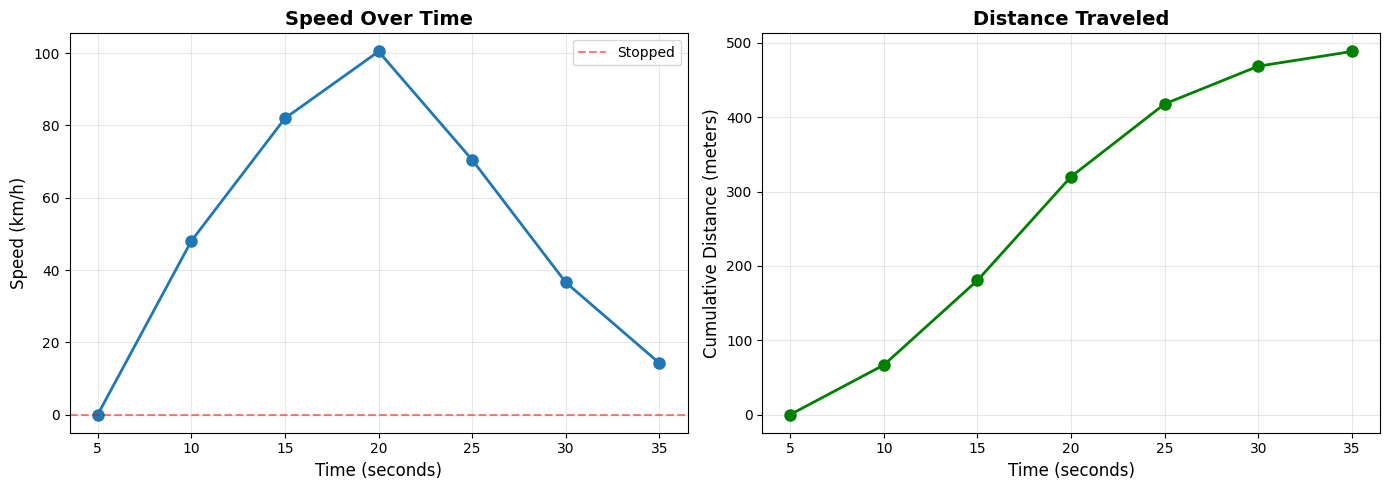


Trip Statistics:
  Total distance: 488.5 meters
  Duration: 35 seconds
  Average speed: 50.3 km/h
  Max speed: 100.5 km/h


In [11]:
# Visualize the trip
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Speed over time
ax1 = axes[0]
valid = df_trip['speed_kmh'].notna()
ax1.plot(df_trip.loc[valid, 'epoch_seconds'], df_trip.loc[valid, 'speed_kmh'],
         marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Speed (km/h)', fontsize=12)
ax1.set_title('Speed Over Time', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Stopped')
ax1.legend()

# Plot 2: Cumulative distance
ax2 = axes[1]
cumulative = df_trip['distance_km'].cumsum()
ax2.plot(df_trip['epoch_seconds'], cumulative * 1000,
         marker='o', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('Cumulative Distance (meters)', fontsize=12)
ax2.set_title('Distance Traveled', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTrip Statistics:")
print(f"  Total distance: {df_trip['distance_km'].sum()*1000:.1f} meters")
print(f"  Duration: {df_trip['epoch_seconds'].max()} seconds")
print(f"  Average speed: {df_trip['speed_kmh'].mean():.1f} km/h")
print(f"  Max speed: {df_trip['speed_kmh'].max():.1f} km/h")

---
## Integration with `speed_pipeline`

In `ml/pipelines.py`, `speed_pipeline` handles segment boundaries:

In [12]:
# Show how speed_pipeline uses these functions
print("""
def speed_pipeline(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    from ml.data.speed import distance_delta, speed

    # Calculate distance and speed
    df = (df
          .pipe(distance_delta, 'closest_lat', 'closest_lon', 'distance_km')
          .pipe(speed, 'distance_km', 'epoch_seconds', 'speed_kmh'))

    # Mark segment boundaries (important!)
    df['_new_segment'] = df['segment_id'] != df['segment_id'].shift(1)

    # Set distance and speed to NaN at segment boundaries
    # (can't calculate speed between different segments)
    df.loc[df['_new_segment'], 'distance_km'] = np.nan
    df.loc[df['_new_segment'], 'speed_kmh'] = np.nan

    return df
""")


def speed_pipeline(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    from ml.data.speed import distance_delta, speed

    # Calculate distance and speed
    df = (df
          .pipe(distance_delta, 'closest_lat', 'closest_lon', 'distance_km')
          .pipe(speed, 'distance_km', 'epoch_seconds', 'speed_kmh'))

    # Mark segment boundaries (important!)
    df['_new_segment'] = df['segment_id'] != df['segment_id'].shift(1)

    # Set distance and speed to NaN at segment boundaries
    # (can't calculate speed between different segments)
    df.loc[df['_new_segment'], 'distance_km'] = np.nan
    df.loc[df['_new_segment'], 'speed_kmh'] = np.nan

    return df



In [13]:
# Demonstrate segment boundary handling
df_segments = pd.DataFrame({
    'segment_id': [1, 1, 1, 2, 2, 2],  # Two segments
    'latitude': [42.7302, 42.7310, 42.7320, 42.7400, 42.7410, 42.7420],
    'longitude': [-73.6762, -73.6762, -73.6762, -73.6800, -73.6800, -73.6800],
    'epoch_seconds': [0, 5, 10, 100, 105, 110]  # Gap between segments
})

# Calculate speed
df_segments = (df_segments
    .pipe(distance_delta, 'latitude', 'longitude', 'distance_km')
    .pipe(speed, 'distance_km', 'epoch_seconds', 'speed_kmh'))

print("Before segment boundary handling:")
print(df_segments)

# Handle segment boundaries
df_segments['_new_segment'] = df_segments['segment_id'] != df_segments['segment_id'].shift(1)
df_segments.loc[df_segments['_new_segment'], 'distance_km'] = np.nan
df_segments.loc[df_segments['_new_segment'], 'speed_kmh'] = np.nan
df_segments = df_segments.drop(columns=['_new_segment'])

print("\nAfter segment boundary handling:")
print(df_segments)
print("\n→ Row 3 (start of segment 2) has NaN speed - can't calculate across segments")

Before segment boundary handling:
   segment_id  latitude  longitude  epoch_seconds  distance_km  speed_kmh
0           1   42.7302   -73.6762              0          NaN        NaN
1           1   42.7310   -73.6762              5     0.088956  64.048278
2           1   42.7320   -73.6762             10     0.111195  80.060347
3           2   42.7400   -73.6800            100     0.942143  37.685729
4           2   42.7410   -73.6800            105     0.111195  80.060347
5           2   42.7420   -73.6800            110     0.111195  80.060347

After segment boundary handling:
   segment_id  latitude  longitude  epoch_seconds  distance_km  speed_kmh
0           1   42.7302   -73.6762              0          NaN        NaN
1           1   42.7310   -73.6762              5     0.088956  64.048278
2           1   42.7320   -73.6762             10     0.111195  80.060347
3           2   42.7400   -73.6800            100          NaN        NaN
4           2   42.7410   -73.6800          

---
## Summary

| Function | Input | Output | Notes |
|----------|-------|--------|-------|
| `distance_delta` | lat/lon columns | distance in km | First row = NaN |
| `speed` | distance + time columns | speed in km/h | First row = NaN |

**Important:** At segment boundaries, speed should be set to NaN since you can't calculate speed between different trips.